## Imports

In [1]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn.ensemble import BaggingClassifier

## Helper Methods

In [2]:
def vertical_sum(row):
    ret = []
    for i in range(1,17):
        cur_sum = 0
        for j in range(16):
            cur_sum += row[(i + 16*j)]
        ret.append(cur_sum/16)
    return ret

def normalize(arr,a,b):
    mn = min(arr)
    mx = max(arr)
    norm_arr = []
    for x in arr:
        cur = x - mn
        cur *= (b - a)
        cur /= mx - mn
        cur += a
        norm_arr.append(cur)
    return norm_arr

cols = []
for i in range(16):
    cols.append('col_'+str(i+1))

## Import and Process Blood Data

In [14]:
df1 = pd.read_csv('../input/data1.csv',header=None,names=['R','F','M','T','Y'],sep=',')
df1 = df1.sample(frac=1,random_state=1).reset_index(drop=True)
x1 = df1.drop(columns=['Y'])
y1 = df1.Y

## Import and Process Digit Data

In [10]:
data = pd.read_csv('../input/data.csv',header=None,sep=' ')
data = data.drop([257],axis=1)
data = data.rename({0:'num'},axis=1)
data = data.loc[data.num.isin([1.0,5.0])]
data = data.sample(frac=1,random_state=1).reset_index(drop=True)
df = data.loc[0:int(0.2*len(data))-1].reset_index(drop=True)
col_vals = df.iloc[:,1:257].apply(vertical_sum,axis=1)
df[cols] = pd.DataFrame(col_vals.values.tolist(), columns=cols)
df['variance'] = normalize(df.iloc[:,257:273].var(axis=1),-1,1)
df['kurtosis'] = normalize(df.iloc[:,257:273].kurtosis(axis=1),-1,1)
x = df[['kurtosis','variance']]
y = df.num

## Analysis with Layers on Transfusion Blood Data

In [3]:
df_out = pd.DataFrame(columns=['number_of_hidden_layers','number_of_neurons','cross_val_score'])
for n_hl in [1,2,5]:
    for n_n in [2,5,10]:
        cur_hl = [n_n] * n_hl
        model_mlp = MLPClassifier(hidden_layer_sizes=tuple(cur_hl),
                                  activation='relu',
                                  solver='adam',
                                  epsilon=0.001,
                                  max_iter=10000,
                                  alpha=0)
        
        df_out.loc[len(df_out)] = [n_hl,n_n,sum(cross_val_score(model_mlp, x1, y1, cv=10,scoring='accuracy'))/10]

df_out.to_excel(('../out_data/layers_vs_neurons_blood_data.xlsx'),index=False)
df_out

,number_of_hidden_layers,number_of_neurons,cross_val_score
0,1.0,2.0,0.548649
1,1.0,5.0,0.612703
2,1.0,10.0,0.621333
3,2.0,2.0,0.762054
4,2.0,5.0,0.698054
5,2.0,10.0,0.767351
6,5.0,2.0,0.710054
7,5.0,5.0,0.715405
8,5.0,10.0,0.762018


## Analysis with Layers/Nodes/RunTime/CVScore on Digit Data

In [4]:
df_out = pd.DataFrame(columns=['number_of_hidden_layers','number_of_neurons','run_time','cross_val_score'])
for n_hl in [1,2,5,10]:
    for n_n in [2,5,10,50,100]:
        cur_hl = [n_n] * n_hl
        model_mlp = MLPClassifier(hidden_layer_sizes=tuple(cur_hl),
                                  activation='relu',
                                  solver='adam',
                                  epsilon=0.001,
                                  max_iter=10000,
                                  alpha=0)
        start = time.time()
        cv = sum(cross_val_score(model_mlp, x, y, cv=10,scoring='accuracy'))/10
        end = time.time()
        df_out.loc[len(df_out)] = [n_hl,n_n,(end - start)*1000,cv]

df_out.to_excel(('../out_data/layers_vs_neurons_digit_data.xlsx'),index=False)
df_out

,number_of_hidden_layers,number_of_neurons,run_time,cross_val_score
0,1.0,2.0,11997.848034,1.000000
1,1.0,5.0,7812.446833,0.963333
2,1.0,10.0,6310.777187,1.000000
3,1.0,50.0,5026.242971,1.000000
4,1.0,100.0,5070.781946,1.000000
5,2.0,2.0,9864.480019,0.848891
6,2.0,5.0,9646.063089,1.000000
7,2.0,10.0,5267.035007,1.000000
8,2.0,50.0,4614.643097,1.000000
9,2.0,100.0,5860.088825,1.000000


## Analysis with Learning Rate/RunTime/CVScore on Digit Data

In [5]:
df_out = pd.DataFrame(columns=['learning_rate','run_time','cross_val_score'])
cur_hl = [10] * 5
x_axis = np.logspace(-3, 2, 20, endpoint=True)
for i in x_axis:
    model_mlp = MLPClassifier(hidden_layer_sizes=tuple(cur_hl),
                              activation='relu',
                              solver='adam',
                              epsilon=0.001,
                              max_iter=10000,
                              alpha=0,
                              learning_rate_init=i)
    start = time.time()
    cv = sum(cross_val_score(model_mlp, x, y, cv=10,scoring='accuracy'))/10
    end = time.time()
    df_out.loc[len(df_out)] = [i,(end - start)*1000,cv]
    
df_out.to_excel(('../out_data/learning_rate_digit_data.xlsx'),index=False)
df_out

,learning_rate,run_time,cross_val_score
0,0.001000,6838.064909,1.000000
1,0.001833,5000.977278,1.000000
2,0.003360,3611.764193,0.996875
3,0.006158,1726.855040,0.996875
4,0.011288,1659.488916,1.000000
5,0.020691,3139.357090,0.962500
6,0.037927,1316.448927,0.996875
7,0.069519,1042.286158,0.963333
8,0.127427,789.720058,0.996875
9,0.233572,674.672842,0.959375


## Plotting Region Plot on optimum MLP Model

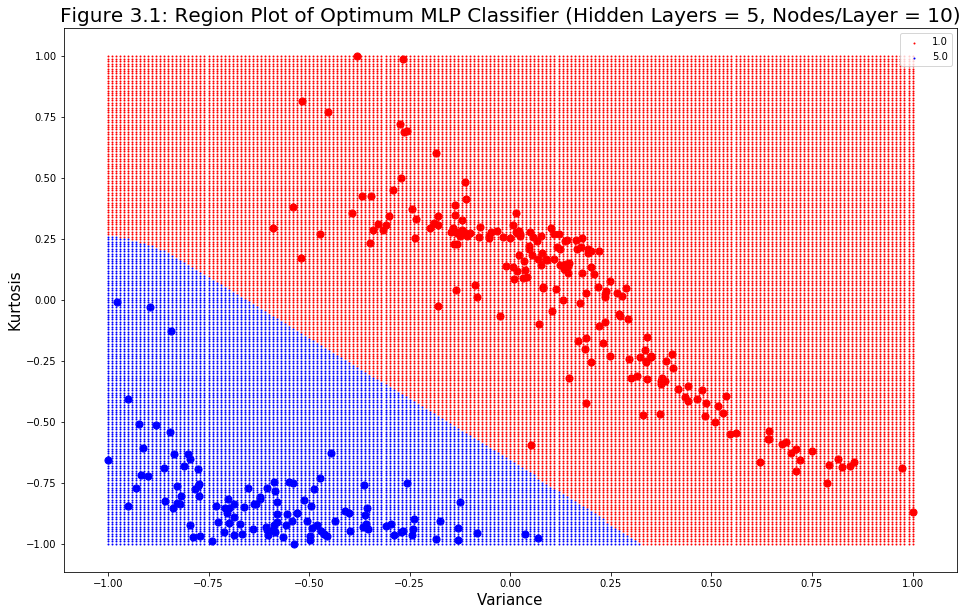

Cross Val Score for this Model: 1.0


In [6]:
cur_hl = [10] * 5
clf = MLPClassifier(hidden_layer_sizes=tuple(cur_hl),
                          activation='relu',
                          solver='adam',
                          epsilon=0.001,
                          max_iter=10000,
                          alpha=0)
clf.fit(x,y)

xPred = []
yPred = []
cPred = []
for xP in range(-100,101):
    xP = xP/100.0
    for yP in range(-100,101):
        yP = yP/100.0
        xPred.append(xP)
        yPred.append(yP)
        cPred.append(clf.predict([[xP,yP]])[0])
        
scatter_x = np.array(xPred)
scatter_y = np.array(yPred)
group = np.array(cPred)
cdict = {1.0: 'red', 5.0: 'blue'}
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(10)
ax.set_title('Figure 3.1: Region Plot of Optimum MLP Classifier (Hidden Layers = 5, Nodes/Layer = 10)',fontsize=20)
plt.xlabel('Variance', fontsize=15)
plt.ylabel('Kurtosis', fontsize=15)

for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 1)

ax.legend()

scatter_x = np.array(df['variance'])
scatter_y = np.array(df['kurtosis'])
group = np.array(df.num)
    
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 50)

plt.show()
fig.savefig('../figures/figure-3_1',dpi=300)
print('Cross Val Score for this Model:',sum(cross_val_score(clf, x, y, cv=10,scoring='accuracy'))/10)

## Multiple Trials of Same model results in different weights

In [7]:
ret = []
for i in range(10):
    model_mlp = MLPClassifier(hidden_layer_sizes=tuple(cur_hl),
                              activation='relu',
                              solver='adam',
                              epsilon=0.001,
                              max_iter=10000,
                              alpha=0)
    model_mlp.fit(x,y)
    cur = []
    for val in model_mlp.coefs_[-1]:
        cur.append(np.round(val,5))
    ret.append(cur)
    
ret[:1]

[[array([-0.56701]),
  array([-0.3302]),
  array([0.66802]),
  array([0.50078]),
  array([0.64254]),
  array([-0.55396]),
  array([0.13731]),
  array([0.36282]),
  array([0.34414]),
  array([0.55993])]]

## Experiments with Early Stopping and Layers

In [8]:
df_out = pd.DataFrame(columns=['Number of Internal Nodes',
                               'CV Score (early_stopping=False)',
                               'Number of Iterations to Converge',
                               'Loss (early_stopping=False)',
                               'CV Score (early_stopping=True)',
                               'Number of Iterations to Converge',
                               'Loss (early_stopping=True)'])

x_axis = np.logspace(0, 2, 5, endpoint=True)
for i in x_axis:
    model_mlp1 = MLPClassifier(hidden_layer_sizes=tuple([int(i)*10]*2),
                              activation='relu',
                              solver='adam',
                              epsilon=0.001,
                              max_iter=10000,
                              alpha=0,
                              early_stopping=False,
                              learning_rate_init=0.001,
                              n_iter_no_change=10,
                              tol=1e-3)
    model_mlp2 = MLPClassifier(hidden_layer_sizes=tuple([int(i)*10]*2),
                              activation='relu',
                              solver='adam',
                              epsilon=0.001,
                              max_iter=10000,
                              alpha=0,
                              early_stopping=True,
                              learning_rate_init=0.001,
                              n_iter_no_change=10,
                              tol=1e-3)
    
    cv1 = sum(cross_val_score(model_mlp1, x1, y1, cv=10,scoring='accuracy'))/10    
    cv2 = sum(cross_val_score(model_mlp2, x1, y1, cv=10,scoring='accuracy'))/10
    model_mlp1.fit(x,y),model_mlp2.fit(x,y)
    df_out.loc[len(df_out)] = [int(i)*10*2,
                               np.round(cv1,5),
                               model_mlp1.n_iter_,
                               np.round(model_mlp1.loss_,5),
                               np.round(cv2,5),
                               model_mlp2.n_iter_,
                               np.round(model_mlp2.loss_,5)]

df_out.to_excel(('../out_data/internal_nodes_early_stopping.xlsx'),index=False)
df_out

,Number of Internal Nodes,CV Score (early_stopping=False),Number of Iterations to Converge,Loss (early_stopping=False),CV Score (early_stopping=True),Number of Iterations to Converge,Loss (early_stopping=True)
0,20.0,0.70112,180.0,0.05243,0.65005,12.0,1.00286
1,60.0,0.74061,131.0,0.03525,0.77004,18.0,0.55554
2,200.0,0.68586,96.0,0.02240,0.74193,28.0,0.39996
3,620.0,0.67405,74.0,0.01683,0.76205,16.0,0.49259
4,2000.0,0.71919,61.0,0.01300,0.76205,28.0,0.13268


## Experiments with Bagging for Extra Credit
### Part 1- Vary the number of estimators for Bagging of NN and Find the Cross Validation Variance

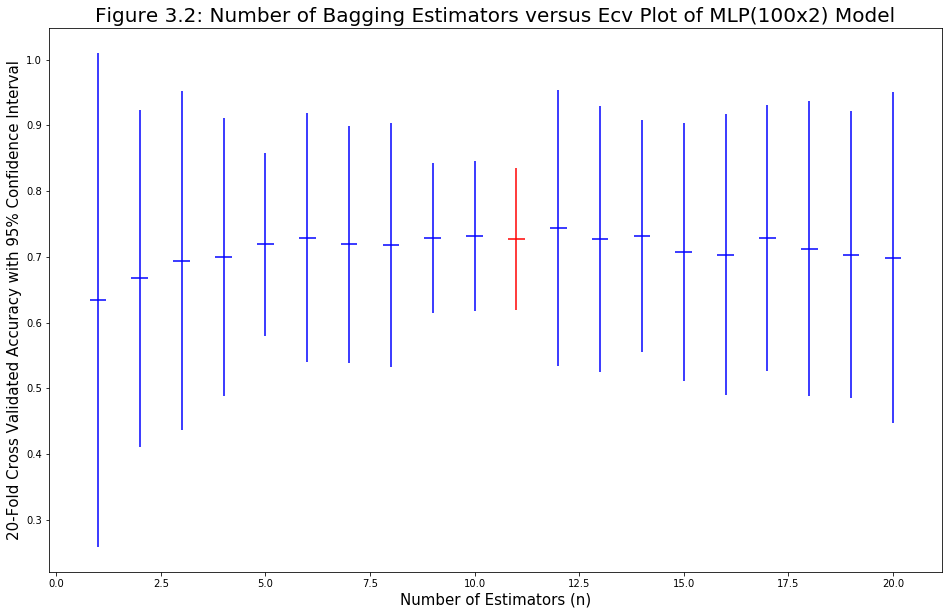

,Number of Bagging estimators,Time Taken,cv_mean,cv_var,cv_std
0,1.0,2.22,0.63455,0.03529,0.18786
1,2.0,3.83,0.66732,0.01644,0.12821
2,3.0,5.91,0.69409,0.01658,0.12876
3,4.0,6.26,0.70010,0.01123,0.10597
4,5.0,6.55,0.71929,0.00482,0.06946
5,6.0,8.25,0.72939,0.00895,0.09463
6,7.0,8.66,0.71929,0.00813,0.09017
7,8.0,9.36,0.71828,0.00858,0.09264
8,9.0,12.88,0.72838,0.00323,0.05687
9,10.0,13.26,0.73192,0.00327,0.05718


In [19]:
# x = df[[72,88]]
# y = df.num
cur_x = x1[:200]
cur_y = y1[:200]
model_mlp = MLPClassifier(hidden_layer_sizes=tuple([100]*2),
                          activation='relu',
                          solver='adam',
                          epsilon=0.001,
                          max_iter=10000,
                          learning_rate_init=0.01,
                          alpha=0)
df_out = pd.DataFrame(columns=['Number of Bagging estimators',
                               'Time Taken',
                               'cv_mean',
                               'cv_var',
                               'cv_std'])
xrange = list(range(1,21,1))
for i in xrange:
    clf = BaggingClassifier(model_mlp,n_estimators=i,n_jobs=-1,random_state=0)
    start = time.time()
    score = cross_val_score(clf, cur_x, cur_y, cv=20,scoring='accuracy')
    end = time.time()
    mean_score = np.round(score.mean(),5)
    var_score = np.round(score.var(),5)
    std_score = np.round(score.std(),5)
    df_out.loc[len(df_out)] = [i,np.round(end-start,2),mean_score,var_score,std_score]

df_out.to_excel(('../out_data/n_bagging_estimators_cross_val_score.xlsx'),index=False)

mean = df_out['cv_mean']
std = df_out['cv_std']

z = mean - 2*std
zmax = np.max(z)
mask = np.array(z) == zmax
color = np.where(mask, 'red', 'blue')

plt.figure(figsize=(16, 10))
plt.xlabel('Number of Estimators (n)',fontsize=15)
plt.ylabel('20-Fold Cross Validated Accuracy with 95% Confidence Interval',fontsize=15)
plt.title('Figure 3.2: Number of Bagging Estimators versus Ecv Plot of MLP(100x2) Model',fontsize=20)
plt.errorbar(xrange, mean, xerr=0.2, yerr=2*std, linestyle='',color=color)
plt.savefig('../figures/figure-3_2',dpi=300)
plt.show()
df_out

In [27]:
def getOptimalBaggingEstimators(model_mlp,cur_x,cur_y,cur_cv):
    df_out = pd.DataFrame(columns=['n_estimators','cv_mean','cv_std'])
    xrange = list(range(1,21,1))
    for i in xrange:
        clf = BaggingClassifier(model_mlp,n_estimators=i,n_jobs=-1,random_state=0)
        score = cross_val_score(clf, cur_x, cur_y, cv=cur_cv,scoring='accuracy')
        mean_score = np.round(score.mean(),5)
        std_score = np.round(score.std(),5)
        df_out.loc[len(df_out)] = [i,mean_score,std_score]
   
    mean = df_out['cv_mean']
    std = df_out['cv_std']
    z = mean - 2*std
    return df_out.loc[np.argmax(np.asarray(z))].n_estimators
    

In [30]:
df_out = pd.DataFrame(columns=['Number Of Hidden Layers',
                               'Nodes Per Hidden Layer',
                               'Optimal Number of Bagging Estimators'])
for n_hl in [2,5]:
    for n_n in [2,5,10,100]:
        cur_hl = [n_n] * n_hl
        model_mlp = MLPClassifier(hidden_layer_sizes=tuple(cur_hl),
                          activation='relu',
                          solver='adam',
                          epsilon=0.001,
                          max_iter=10000,
                          learning_rate_init=0.01,
                          alpha=0)
        n = getOptimalBaggingEstimators(model_mlp,cur_x,cur_y,20)
        df_out.loc[len(df_out)] = [n_hl,n_n,n]

df_out.to_excel(('../out_data/complexity_n_bagging_estimators.xlsx'),index=False)
df_out

,Number Of Hidden Layers,Nodes Per Hidden Layer,Optimal Number of Bagging Estimators
0,2.0,2.0,1.0
1,2.0,5.0,20.0
2,2.0,10.0,3.0
3,2.0,100.0,11.0
4,5.0,2.0,1.0
5,5.0,5.0,17.0
6,5.0,10.0,18.0
7,5.0,100.0,9.0
